### Autoencoders

Definición: https://www.ibm.com/es-es/topics/autoencoder 

Tipos:[ \[link\]](https://deeplearningofpython.blogspot.com/2023/05/Typesofautoencoders-implementation-keras.html?source=post_page-----383cfecc4d0e--------------------------------)

Como funcionan: https://www.geeksforgeeks.org/how-autoencoders-works/ 

Compresión de imágenes y regeneración de imágenes

- latent space: https://www.geeksforgeeks.org/what-is-latent-space-in-deep-learning/ 

- Reconstrucción imágenes a partir del espacio latente https://medium.com/@jaiganesan/autoencoder-is-simple-9055a7b5b935 

- Calidad de reconstrucción y pérdida de información: https://medium.com/@bhipanshudhupar/loss-functions-in-simple-autoencoders-mse-vs-l1-loss-4e838ae425b9 

In [34]:
import torchvision.transforms as transforms
from torch.utils.data import  DataLoader
from torchvision.datasets import CIFAR10
import torchvision
import matplotlib.pyplot as plt


In [35]:
TRAINING_SIZE=15
TEST_SIZE=10

### Load Cifar10

In [ ]:
training_set = CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))
test_set = CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

In [37]:
print(len(training_set))
print(len(test_set))

50000
10000


In [38]:
print(training_set[0][0].shape)

torch.Size([3, 32, 32])


Normalization?

In [39]:
train_dl = DataLoader(training_set, batch_size=TRAINING_SIZE,shuffle=True, num_workers=2)
test_dl = DataLoader(test_set, batch_size=TEST_SIZE,shuffle=True, num_workers=2)

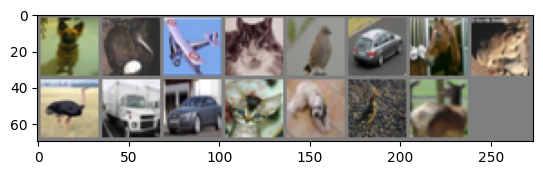

In [40]:
images, labels = next(iter(train_dl))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0) / 2 + 0.5); 

### Model Architecture

#### Encode

#### BottleNeck

#### Decoder